# Finetune [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) using LoRA
Loss function used: `CosineSimilarityLoss`

In [1]:
from transformers import AutoModel, AutoTokenizer, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
torch.manual_seed(0)
np.random.seed(0)

## Load model

In [2]:
model_name = "sentence-transformers/paraphrase-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
model

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

## Configure LoRA using [peft](https://huggingface.co/docs/peft/en/index) library

In [4]:
config = LoraConfig(
    r = 8,
    lora_alpha=16,
    lora_dropout=0.05,
    task_type="FEATURE_EXTRACTION",
    target_modules=["q", "v", "k", "o"]
)

model = get_peft_model(model, config)
# model = inject_adapter_in_model(model, config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 110,076,288 || trainable%: 0.5358


In [5]:
batch_size = 8

args = TrainingArguments(
    output_dir="train_output",
    eval_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_dir="train_logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

## Load data

In [6]:
df_ques_url_train = pd.read_pickle('../../data/questions_relevant_urls_chunks_train.pkl')
print(df_ques_url_train.shape)
df_ques_url_train.head()

(20000, 3)


,question,relevant_docs_urls,num_rel_chunks
0,What is (are) keratoderma with woolly hair ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
1,How many people are affected by keratoderma wi...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
2,What are the genetic changes related to kerato...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
3,Is keratoderma with woolly hair inherited ?,[https://ghr.nlm.nih.gov/condition/keratoderma...,5
4,What are the treatments for keratoderma with w...,[https://ghr.nlm.nih.gov/condition/keratoderma...,5


In [7]:
df_kb = pd.read_pickle('../../data/kb_chunks_emb.pkl')
print(df_kb.shape)
df_kb.head(3)

(33545, 3)


,doc_url,chunk_content,embedding
0,https://ghr.nlm.nih.gov/condition/keratoderma-...,keratoderma with woolly hair : medlineplus gen...,"[-0.0039987266, 0.08037464, 0.049785912, -0.12..."
1,https://ghr.nlm.nih.gov/condition/keratoderma-...,"##ma, woolly hair, and a form of cardiomyopath...","[-0.09539697, -0.09132044, 0.0027289127, 0.005..."
2,https://ghr.nlm.nih.gov/condition/keratoderma-...,##pathy in people with this group of condition...,"[0.026278932, 0.060939535, 0.031438153, -0.044..."


In [ ]:
def create_pairs(df_ques_url, df_kb, train_size):
    """
    For every question, choose a random relevant document and a random chunk from that document.
    """
    pairs = []

    for i in range(train_size):
        query = df_ques_url['question'][i]
        rel_docs = df_ques_url['relevant_docs_urls'][i]
        # Choose a random relevant doc
        rel_doc = np.random.choice(rel_docs)
        # Choose a chunk from the relevant doc
        rel_doc_chunk = df_kb[df_kb['doc_url'] == rel_doc]['chunk_content'].values[0]
        pairs.append((query, rel_doc_chunk))

    return pairs

TRAIN_SIZE = 12_000
train_pairs = create_pairs(df_ques_url_train, df_kb, TRAIN_SIZE)

In [9]:
from torch.utils.data import Dataset
import torch.nn.functional as F

class BioDataset(Dataset):
    def __init__(self, pairs, tokenizer):
        self.pairs = pairs
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        query, doc = self.pairs[idx]
        inputs = self.tokenizer([query, doc], padding="max_length", truncation=True, return_tensors="pt")
        inputs["label"] = 1.0
        return inputs
    
train_dataset = BioDataset(train_pairs, tokenizer)

In [10]:
train_dataset[0]['input_ids'].shape

torch.Size([2, 512])

In [11]:
# Collate function

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'].squeeze() for item in batch])
    attention_mask = torch.stack([item['attention_mask'].squeeze() for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [12]:
BATCH_SIZE = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [13]:
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape, batch["attention_mask"].shape, batch["labels"].shape)

torch.Size([16, 2, 512]) torch.Size([16, 2, 512]) torch.Size([16])


In [14]:
# Forward pass on the model without gradients
with torch.no_grad():
    outputs = model(
        input_ids=batch["input_ids"].view(-1, batch["input_ids"].size(-1)),
        attention_mask=batch["attention_mask"].view(-1, batch["attention_mask"].size(-1))
    )

for k, v in outputs.items():
    print(k, v.shape)

last_hidden_state torch.Size([32, 512, 768])
pooler_output torch.Size([32, 768])


## Fine-tune using LoRA

In [15]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer model to the device
model.to(device)
print("Model loaded on device", flush=True)

Model loaded on device


In [16]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [17]:
from torch.optim import AdamW
from torch.nn import CosineEmbeddingLoss

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr=args.learning_rate)
loss_fn = CosineEmbeddingLoss()

In [18]:
# Training loop
losses = []
for epoch in range(args.num_train_epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        optimizer.zero_grad()

        # Move inputs to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch["input_ids"].view(-1, batch["input_ids"].size(-1)),
            attention_mask=batch["attention_mask"].view(-1, batch["attention_mask"].size(-1))
        )

        embeddings = mean_pooling(outputs, batch["attention_mask"].view(-1, batch["attention_mask"].size(-1)))

        # print(embeddings.shape) # (2*batch_size, emb_dim)

        # Compute cosine similarity loss
        labels = batch["labels"].float()
        loss = loss_fn(embeddings[::2], embeddings[1::2], labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        if (i % 100 == 0):
            if i > 0:
                avg_loss = total_loss / ((i+1) * batch_size)
            else:
                avg_loss = total_loss
            print("Loss: ", avg_loss, flush=True)
            losses.append(avg_loss)
        
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}", flush=True)

Epoch 1:   0%|          | 0/750 [00:00<?, ?it/s]

Loss:  0.3819962739944458


Epoch 1:  13%|█▎        | 100/750 [01:27<09:46,  1.11it/s]

Loss:  0.027909482214599848


Epoch 1:  27%|██▋       | 200/750 [02:54<07:57,  1.15it/s]

Loss:  0.01567565608303994


Epoch 1:  40%|████      | 300/750 [04:22<06:37,  1.13it/s]

Loss:  0.010665949021155635


Epoch 1:  53%|█████▎    | 400/750 [05:50<05:04,  1.15it/s]

Loss:  0.008117907597916202


Epoch 1:  67%|██████▋   | 500/750 [07:18<03:35,  1.16it/s]

Loss:  0.006575148824602366


Epoch 1:  80%|████████  | 600/750 [08:47<02:12,  1.13it/s]

Loss:  0.005540295375200609


Epoch 1:  93%|█████████▎| 700/750 [10:03<00:27,  1.80it/s]

Loss:  0.004796096480983708


Epoch 1: 100%|██████████| 750/750 [10:31<00:00,  1.19it/s]

Epoch 1 - Average Loss: 0.0360



Epoch 2:   0%|          | 0/750 [00:00<?, ?it/s]

Loss:  0.002311035990715027


Epoch 2:  13%|█▎        | 100/750 [00:55<06:03,  1.79it/s]

Loss:  0.0003031005710363388


Epoch 2:  27%|██▋       | 200/750 [01:51<05:06,  1.80it/s]

Loss:  0.0002966525638476014


Epoch 2:  40%|████      | 300/750 [02:47<04:11,  1.79it/s]

Loss:  0.0002872750566651424


Epoch 2:  53%|█████▎    | 400/750 [03:43<03:16,  1.78it/s]

Loss:  0.0002815540903247893


Epoch 2:  67%|██████▋   | 500/750 [04:39<02:20,  1.78it/s]

Loss:  0.0002754882127046585


Epoch 2:  80%|████████  | 600/750 [05:35<01:24,  1.77it/s]

Loss:  0.00027036793529987334


Epoch 2:  93%|█████████▎| 700/750 [06:32<00:28,  1.78it/s]

Loss:  0.00026484632066317966


Epoch 2: 100%|██████████| 750/750 [07:00<00:00,  1.79it/s]

Epoch 2 - Average Loss: 0.0021



Epoch 3:   0%|          | 0/750 [00:00<?, ?it/s]

Loss:  0.0015871524810791016


Epoch 3:  13%|█▎        | 100/750 [00:55<06:02,  1.79it/s]

Loss:  0.00022204506676644088


Epoch 3:  27%|██▋       | 200/750 [01:51<05:06,  1.79it/s]

Loss:  0.00021848021540790796


Epoch 3:  40%|████      | 300/750 [02:47<04:12,  1.79it/s]

Loss:  0.0002134378689030806


Epoch 3:  53%|█████▎    | 400/750 [03:43<03:15,  1.79it/s]

Loss:  0.0002101769857108593


Epoch 3:  67%|██████▋   | 500/750 [04:39<02:19,  1.80it/s]

Loss:  0.00020684057101607323


Epoch 3:  80%|████████  | 600/750 [05:35<01:24,  1.78it/s]

Loss:  0.00020345735286052028


Epoch 3:  93%|█████████▎| 700/750 [06:31<00:28,  1.78it/s]

Loss:  0.00020038182780678784


Epoch 3: 100%|██████████| 750/750 [06:59<00:00,  1.79it/s]

Epoch 3 - Average Loss: 0.0016



Epoch 4:   0%|          | 0/750 [00:00<?, ?it/s]

Loss:  0.0015876330435276031


Epoch 4:  13%|█▎        | 100/750 [00:55<06:03,  1.79it/s]

Loss:  0.00017528498079627753


Epoch 4:  27%|██▋       | 200/750 [01:51<05:07,  1.79it/s]

Loss:  0.00016957935178652406


Epoch 4:  40%|████      | 300/750 [02:47<04:11,  1.79it/s]

Loss:  0.0001657046750187874


Epoch 4:  53%|█████▎    | 400/750 [03:43<03:15,  1.79it/s]

Loss:  0.00016306375036947429


Epoch 4:  67%|██████▋   | 500/750 [04:39<02:20,  1.78it/s]

Loss:  0.00016018486116081476


Epoch 4:  80%|████████  | 600/750 [05:35<01:23,  1.79it/s]

Loss:  0.0001576811292519172


Epoch 4:  93%|█████████▎| 700/750 [06:31<00:27,  1.80it/s]

Loss:  0.00015491159832371133


Epoch 4: 100%|██████████| 750/750 [06:59<00:00,  1.79it/s]

Epoch 4 - Average Loss: 0.0012



Epoch 5:   0%|          | 0/750 [00:00<?, ?it/s]

Loss:  0.0010018013417720795


Epoch 5:  13%|█▎        | 100/750 [00:55<06:04,  1.78it/s]

Loss:  0.0001308137457817793


Epoch 5:  27%|██▋       | 200/750 [01:51<05:07,  1.79it/s]

Loss:  0.00012996651930734514


Epoch 5:  40%|████      | 300/750 [02:48<04:13,  1.78it/s]

Loss:  0.00012878939198950927


Epoch 5:  53%|█████▎    | 400/750 [03:44<03:16,  1.78it/s]

Loss:  0.00012698296923190354


Epoch 5:  67%|██████▋   | 500/750 [04:40<02:20,  1.78it/s]

Loss:  0.00012431110348552464


Epoch 5:  80%|████████  | 600/750 [05:36<01:23,  1.80it/s]

Loss:  0.00012262493294353286


Epoch 5:  93%|█████████▎| 700/750 [06:32<00:27,  1.80it/s]

Loss:  0.0001201412341158305


Epoch 5: 100%|██████████| 750/750 [07:00<00:00,  1.79it/s]

Epoch 5 - Average Loss: 0.0010


**Note:** Takes 10 GB of GPU memory for batch size of 8, 20GB for batch size of 16

In [19]:
# Save the model
model_save_path = "mpnet_peft_ft"
model.save_pretrained(model_save_path)
print(f"Model saved at {model_save_path}", flush=True)

Model saved at mpnet_peft_ft


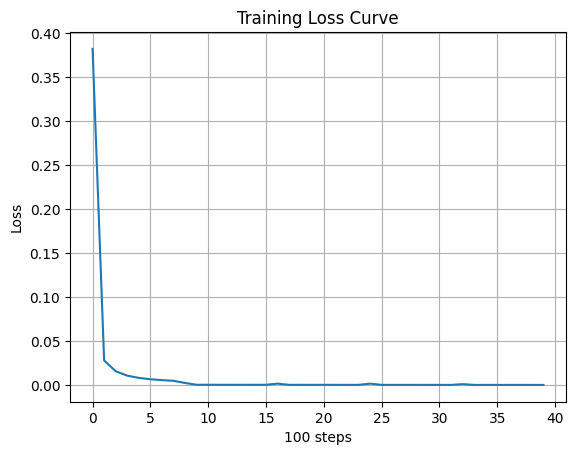

: 

In [ ]:
# Loss curve
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("100 steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()